In [1]:
import tensorflow as tf
from tensorflow import keras

In [15]:
import numpy as np

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full,X_test,y_train_full,y_test = train_test_split(housing.data,housing.target)
X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

신경망은 조정할 하이퍼파라미터가 많은 유연성을 장점이자 단점으로 가지고 있다. 여러 층의 퍼셉트론에서도 층의 개수, 뉴런의 개수, 각 층에 사용할 활성화 함수, 가중치 초기화 전략 등 바꿀 수 있는 것이 많다.

GridSearchCV나 RandomizedSearchCV를 사용해 하이퍼파라미터 공간을 탐색할 수 있다.

In [2]:
# 입력받은 여러 변수들로부터 Sequential 모델을 만드는 함수
def build_model(n_hidden=1,n_neurons=30, learning_rate=3e-3, input_shape=[8]):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons,activation='relu'))
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.SGD(lr=learning_rate)
  model.compile(loss='mse',optimizer=optimizer)
  return model

In [3]:
# KerasRegressor 클래스의 객체 : build_model()함수로 만들어진 케라스 모델을 감싸는 간단한 래퍼(wrapper). 일반적인 사이킷런 회귀 추정기처럼 사용가능
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [7]:
history = keras_reg.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid),
              callbacks = [keras.callbacks.EarlyStopping(patience=10)])

mse_test = keras_reg.score(X_test,y_test)
X_new = X_test[:3]
y_pred = keras_reg.predict(X_new)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 1.4171 - val_loss: 0.6638
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.6804 - val_loss: 0.5974
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5732 - val_loss: 0.5692
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5405 - val_loss: 0.5343
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5157 - val_loss: 0.5170
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5008 - val_loss: 0.5073
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4890 - val_loss: 0.4946
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4799 - val_loss: 0.4874
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4710 - val_loss: 0.4806
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4648 - val_lo

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

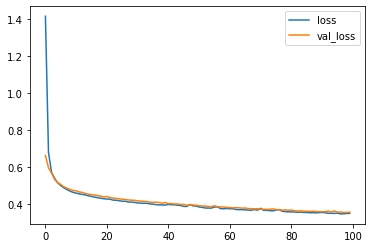

In [13]:
pd.DataFrame(history.history).plot()

## 파라미터 선택
모델 하나를 훈련하고 평가하려는 것이 아니라 수백 개의 모델을 훈련하고 검증 세트에서 최상의 모델을 선택해야한다. <br>
하이퍼파라미터가 많으므로 그리드 탐색보다는 랜덤 탐색(파라미터를 연속적인 범위로 지정 가능)을 수행해야한다.

In [17]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden':[0,1,2,3],
    'n_neurons':np.arange(1,100),
    'learning_rate':reciprocal(3e-4,3e-2)
}

# k-fold 교차 검증을 사용하기에 X_valid, y_valid는 사용하지 않는다.
rnd_search_cv = RandomizedSearchCV(keras_reg,param_distribs, n_iter=10,cv=3)
rnd_search_cv.fit(X_train,y_train,epochs=100,
                   validation_data=(X_valid,y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 1.0687 - val_loss: 0.6534
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6002 - val_loss: 0.5582
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5329 - val_loss: 0.5178
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4965 - val_loss: 0.4917
Epoch 5/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4723 - val_loss: 0.4731
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4584 - val_loss: 0.4592
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4464 - val_loss: 0.4485
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4366 - val_loss: 0.4443
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4296 - val_loss: 0.4359
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4229 - val_lo

RuntimeError: ignored

In [18]:
# 예기치 않은 에러가 나긴 했지만 best한 모델을 기억하는듯
rnd_search_cv.best_params_

{'learning_rate': 0.004228574963849812, 'n_hidden': 2, 'n_neurons': 97}

In [19]:
# 사이킷런은 손실이 아니라 점수를 기억하기 때문에 (클수록 좋다) 출력 점수는 음수의 MSE이다.
rnd_search_cv.best_score_

-0.3146134515603383

랜덤 탐색을 시행하는 것은 크게 어렵지 않으나 훈련시간이 많이 걸리면 탐색할 수 있는 하이퍼파라미터 공간에 제약이 생긴다.

탐색 과정을 수동으로 보조하여 이 문제를 부분적으로 완화할 수 있다. 하이퍼파라미터 값의 범위를 크게 하여 빠르게 첫 번째 랜덤 탐색을 수행하고, 첫 번째 탐색에서 찾은 최상의 하이퍼파라미터 값을 중심으로 더 좁은 범위를 탐색한다.

더 효율적인 방법으로 여러 가지 기법들이 있다.<br>
(하이퍼파라미터 최적화에 사용할 수 있는 몇 개의 파이썬 라이브러리
- Hyperopt 
- Hyperas, Kopt, Talos : 케라스 모델을 위한 하이퍼파라미터 최적화 라이브러리
- keras Tuner
- Scikit-Optimizer
- Spearmint : 베이즈 최적화 라이브러리
- Hyperband
- Sklearn-Deap

# 은닉층 개수
심층 신경망은 복잡한 함수를 모델링하는데 더 얕은 신경망보다 훨씬 적은 수의 뉴런을 사용하므로 동일한 양의 훈련 데이터에서 더 높은 성능을 낼 수 있다.

계층 구조(입력층과 아래쪽 은닉층은 저수준, 중간 은닉층은 저수준을 연결해 중간 수준의 구조를 모델링, 가장 위쪽 은닉층과 출력층은 중간 수준의 구조를 연결해 고수준의 구조를 모델링)는 심층 신경망이 좋은 솔루션으로 빨리 수렴하게끔 도와준다. <br>
새로운 샘플을 인식하는 신경망을 새로 훈련할 때 이전 샘플에 대한 첫 번째 네트워크의 하위 층을 재사용하여 훈련을 시작할 수 있다. 새로운 신경망에서 처음 몇 개 층의 가중치와 편향을 난수로 초기화하는 대신 첫 번째 신경망의 층에 있는 가중치와 편향값으로 초기화할 수 있다. ("전이학습, transfer learning", 11장에서 자세히) 

비슷한 작업에서 가장 뛰어난 성능을 낸 미리 훈련된 네트워크 일부를 재사용하는 것이 훈련 속도는 훨씬 빠르고 데이터도 적게 필요하므로 일반적이다.

# 은닉층의 뉴런 개수
입력층과 출력층의 뉴런 개수는 해당 작업에 필요한 입,출력 형태에 따라 결정된다. 예를 들어 MNIST 같은 경우 28x28개의 입력 뉴런, 10개의 출력 뉴런이 필요하다.

은닉층의 구성 방식은 일반적으로 각 층의 뉴런을 점점 줄여 깔대기처럼 구성한다. 저수준의 많은 특성이 고수준의 적은 특성으로 합쳐질 수 있기 때문이다. 예를 들어 MNIST 신경망을 구성하는 전형적인 방법은 (28x28=784->)300->200->100개의 뉴런으로 구성되는 3개의 은닉층으로 설정하는 것이다.

대부분의 경우 모든 은닉층에 같은 크기를 사용해도 동일하거나 더 나은 성능을 낸다. 또 튜닝할 하이퍼파리미터가 층마다 한 개씩이 아니라 전체를 통틀어 한 개가 되기도 한다. 데이터에 따라 다르지만 다른 은닉층보다는 첫 번째 은닉층을 크게 하는 것이 좋다.

뉴런의 수가 너무 적으면 입력에 유용한 정보를 모두 유지하기 위한 충분한 표현 능력을 가지지 못한다. 예를 들어 뉴런 2개만 가진 층은 2D 데이터만 출력할 수 있다. 만일 3D 데이터를 처리한다면 일부 정보를 잃게 된다. 나머지 네트워크 층이 얼마나 강력한지에 관계없이 손실된 정보는 복원되지 않는다.

# 학습률
일반적으로 최적의 학습률은 최대 학습률(훈련 알고리즘이 발산)의 절반 가량이다.

점진적으로 매우 작은 학습률에서 시작해 반복마다 일정한 값을 곱해 큰 학습률까지 수백 번 모델을 훈련한다. 최적의 학습률은 손실이 상승하는 지점보다 조금 아래에 있을 것이다.

# 옵티마이저
11장 참고

# 배치 크기
큰 배치의 장점은 GPU와 같은 하드웨어 가속기를 효율적으로 활용할 수 있다는 점이다. GPU 램에 맞는 가장 큰 배치를 사용하는 것이 좋다. 

학습률 예열을 사용해 큰 배치를 시도한 후 훈련이 불안적하거나 최종 성능이 만족스럽지 못하다면 작은 배치를 사용하는게 좋다.

# 활성화 함수
수행하는 작업의 종류에 따라 달라진다.

# 반복 횟수
반복 횟수를 튜닝할 필요는 없고 조기 종료를 사용한다.